This Kaggle competition is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others' submissions. Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. As a mini-project to complete as a weekly assignment, we don't expect you to iterate over your project until you have a model capable of winning the challenge. The iterative process takes time, so please start early to get better-quality results and reports. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project. The grades are more based on the quality and depth of the analysis, not just on a better Kaggle score.

You will submit three deliverables: 

Deliverable 1 — A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion. 

Suppose your work becomes so large that it doesn’t fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead. 

If your project doesn’t fit into Jupyter notebook format (E.g., you built an app that uses ML), write your approach as a report and submit it in a pdf form. 

Deliverable 2 — A public project GitHub repository with your work (please also include the GitHub repo URL in your notebook/report).

Deliverable 3 — A screenshot of your position on the Kaggle competition leaderboard for your top-performing model.

github：https://github.com/zpeople/CNN_cancer_detection

[08/16/2024 Fri 10:56:39] BY Renmin Zhao

 ## Step1
 ### Brief description of the problem and data (5 pts) 

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from glob import glob
from PIL import Image

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
#load data

labels_df = pd.read_csv("train_labels.csv")

labels_df.shape
labels_df.head()

(220025, 2)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [51]:
labels_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [52]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


       Label Counts
label              
0            130908
1             89117


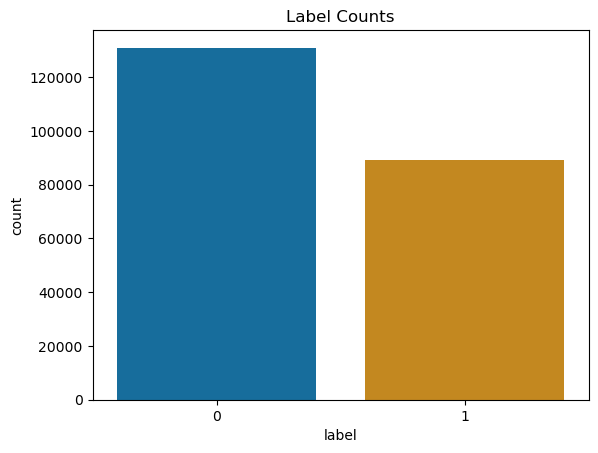

In [3]:
print(pd.DataFrame(data={'Label Counts': labels_df['label'].value_counts()}))
sns.countplot(x=labels_df['label'], palette='colorblind').set(title='Label Counts');

In [4]:
imgs_path_df = pd.DataFrame(glob("train/*.tif"), columns = ["path"])
imgs_path_df["id"] = imgs_path_df["path"].map(lambda x: x.split("\\")[-1].split(".")[0])
imgs_path_df.shape
imgs_path_df.head()

(220025, 2)

,path,id
0,train\00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5
1,train\000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598
2,train\00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1
3,train\0000d563d5cfafc4e68acb7c9829258a298d9b6a...,0000d563d5cfafc4e68acb7c9829258a298d9b6a
4,train\0000da768d06b879e5754c43e2298ce48726f722...,0000da768d06b879e5754c43e2298ce48726f722


In [5]:
#merge data
df = pd.merge(imgs_path_df, labels_df, on = "id", how = "left")
df.shape
df.head()

(220025, 3)

,path,id,label
0,train\00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,train\000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,train\00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,train\0000d563d5cfafc4e68acb7c9829258a298d9b6a...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,train\0000da768d06b879e5754c43e2298ce48726f722...,0000da768d06b879e5754c43e2298ce48726f722,1


## Step2

### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

train\d616059f2df97b4398730901cf1c2f55fe2f4b1b.tif
Image shape: (96, 96, 3)
train\9bdca69670872c68f01d34f2aba4cd4d5bad104f.tif
Image shape: (96, 96, 3)
train\e9615b9803ff845aa44ea0bc8dd6f5afa3287c3e.tif
Image shape: (96, 96, 3)
train\d9b958cb0698e88e1fec349581b4da4b01e9fca1.tif
Image shape: (96, 96, 3)
train\c6b25a357d155861dc4d3de72b13a7c8dfd4fa19.tif
Image shape: (96, 96, 3)
train\8ae95c5ba2299fd0ce43cf5467042ccda9c293aa.tif
Image shape: (96, 96, 3)
train\327856e8014e563211fd8dac354d09142e6cdd79.tif
Image shape: (96, 96, 3)
train\ec9aaf0b32d088671007547bb74285b8d10e4134.tif
Image shape: (96, 96, 3)
train\15831c3315a7cb98621be8c82209823c2159ebc4.tif
Image shape: (96, 96, 3)
train\6ad8ce88201a827295edc2696aef28f11224b927.tif
Image shape: (96, 96, 3)


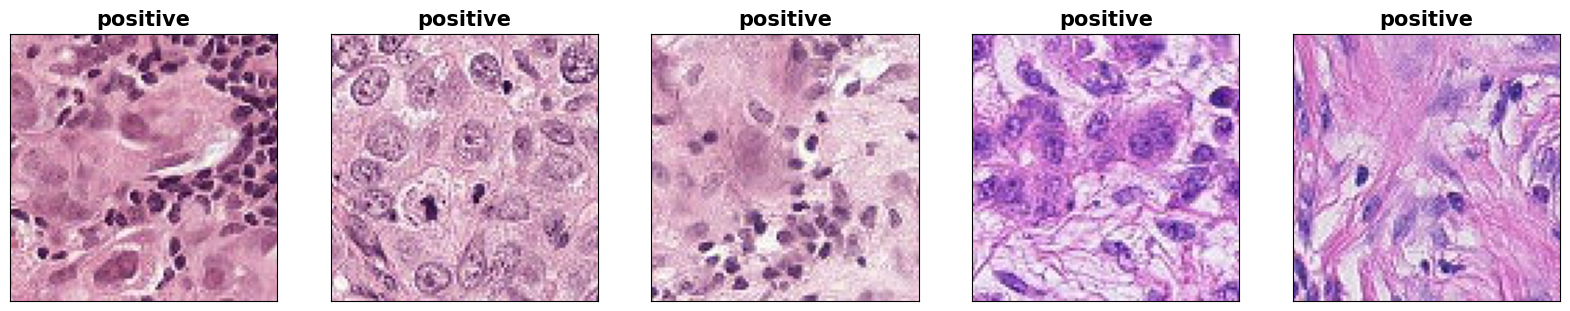

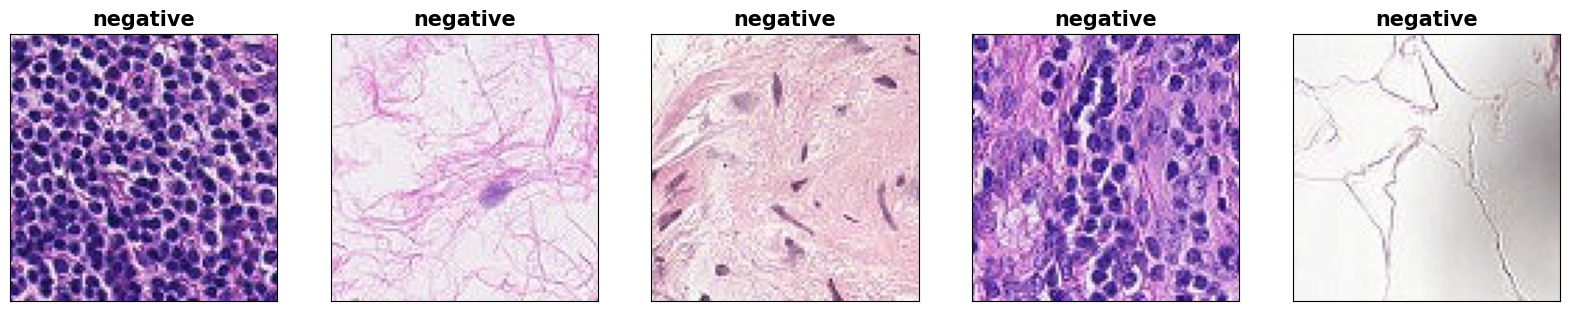

In [23]:
#Visualize image
def drawImage(df,title):
    fig, ax = plt.subplots(1, 5, figsize = (20, 5))

    random_num = list(np.random.randint(0, df.shape[0] - 1, size = 5))
    for i,j in enumerate(random_num):
        image_path =df.iloc[j]["path"]
        print(image_path)
        image_data =np.asarray(Image.open(image_path))
        print('Image shape:',image_data.shape) #(batch_size, height, width, channels)
        ax[i].imshow(image_data)
        ax[i].set_xticks([])
        
        ax[i].set_yticks([])
        ax[i].set_title(title,fontsize = 15, fontweight = "bold")
        
        
df_1 =df[df["label"] == 1]
df_0 =df[df["label"] == 0]
drawImage(df_1,'positive')
drawImage(df_0,'negative')

In [6]:
#split train and valid data
index = np.random.permutation(df.shape[0])
df = df.iloc[index]
train_count =12000 #Adjust the training data for performance
df[:train_count]["label"].value_counts(normalize=True)

train, valid = train_test_split(df[:train_count], test_size = 0.2, stratify = df[:train_count]["label"], random_state = 0)

train.shape


label
0    0.60075
1    0.39925
Name: proportion, dtype: float64

(9600, 3)

## Step3

### DModel Architecture (25 pts)

escribe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

In [7]:
import tensorflow as tf

from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation


from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

RANDOM_STATE = 42
BATCH_SIZE = 96
TARGET_SIZE =(96,96)   # original image (96, 96)  resize will increases the duration of load
INPUT_SHAPE=(96,96,3)
ROC = tf.keras.metrics.AUC()
EPOCH =20


train["label"] = train["label"].astype(str)
valid["label"] = valid["label"].astype(str)



# Pixel values are normalized to 0-1, while data augmentation methods such as horizontal, vertical, rotation, and scaling transformations are used
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    vertical_flip = True,
    horizontal_flip = True,
    rotation_range = 90,
    zoom_range = 0.2, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.05,
    channel_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train, 
    directory = None, 
    x_col = "path", 
    y_col = "label", 
    target_size =TARGET_SIZE, 
    class_mode = "binary", 
    batch_size = BATCH_SIZE, 
    seed = RANDOM_STATE, 
    shuffle = True
)


valid_datagen = ImageDataGenerator(
    rescale = 1 / 255
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = valid, 
    directory = None, 
    x_col = "path", 
    y_col = "label", 
    target_size = TARGET_SIZE, 
    class_mode = "binary", 
    batch_size = BATCH_SIZE, 
    seed = RANDOM_STATE, 
    shuffle = False
)



Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.


In [8]:

# Optional: Restrict TensorFlow to only use the first GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) >0:
    print(physical_devices)
    try:
    
        tf.config.set_visible_devices(devices=physical_devices[0], device_type='GPU')
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    
logical_devices = tf.config.list_logical_devices('GPU')
print(f"Physical GPUs: {len(physical_devices)}, Logical GPUs: {len(logical_devices)}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical GPUs: 1, Logical GPUs: 1


In [9]:
# common train config
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size
earlystopper = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1, restore_best_weights = True)  
reducelr = ReduceLROnPlateau(monitor = "val_loss", patience = 3, verbose = 1, factor = 0.1)


####  MY_VGG16 

The model have be done by using  models.Model. VGG16 is a classical convolutional neural network architecture consisting of 16 layers (13 convolutional layers and 3 fully connected layers).
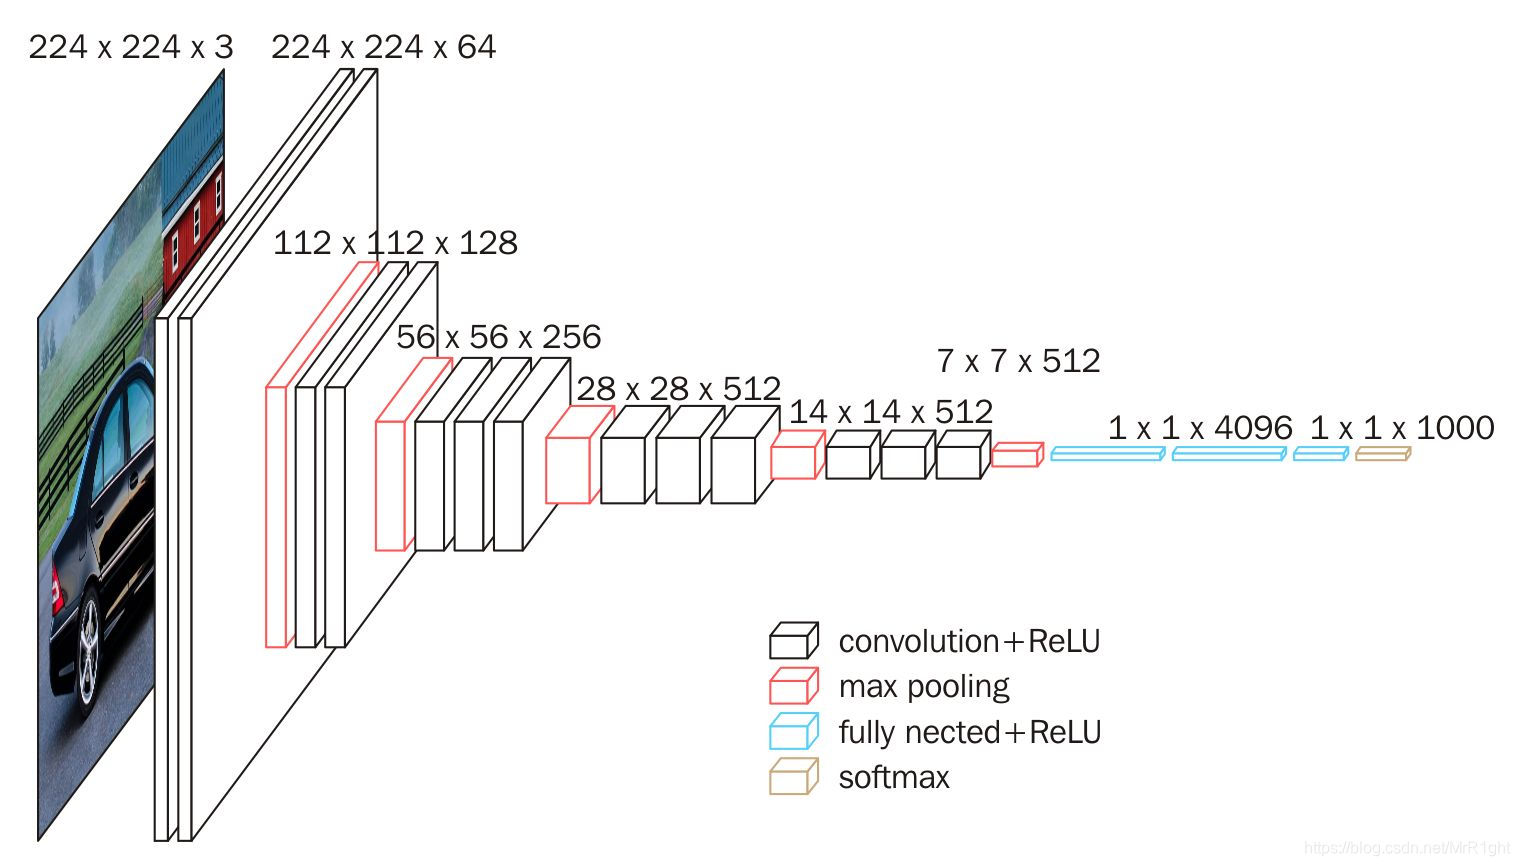

In [ ]:
#VGG 16
import tensorflow as tf
K.clear_session()
# Define the input

inputs = Input(shape=INPUT_SHAPE)
# Block 1
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
x = layers.Dropout(0.5)(x)  # Add Dropout after Block 3

# Block 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

# Block 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
x = layers.Dropout(0.5)(x)  # Add Dropout after Block 5

# Flatten and Dense layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)  # Add Dropout after Dense layer
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)  # Add Dropout after Dense layer
outputs = layers.Dense(1, activation = "sigmoid")(x)

# Create the model
my_VGG16 = models.Model(inputs=inputs, outputs=outputs)

# Print the model summary
my_VGG16.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0     

In [ ]:

lr =0.001
my_VGG16.compile(optimizers.Adam(lr), loss = "binary_crossentropy", metrics = ["accuracy",ROC])

vgg_history = my_VGG16.fit(train_generator, steps_per_epoch = train_step_size, epochs = EPOCH, 
                                validation_data = valid_generator, validation_steps = valid_step_size, 
                                callbacks = [reducelr,earlystopper], verbose = 1)

Epoch 1/20
100/100 [==============================] - 212s 2s/step - loss: 0.9116 - accuracy: 0.5914 - auc: 0.6292 - val_loss: 0.6750 - val_accuracy: 0.5938 - val_auc: 0.5394 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 79s 785ms/step - loss: 0.7230 - accuracy: 0.6978 - auc: 0.7687 - val_loss: 0.8196 - val_accuracy: 0.4225 - val_auc: 0.5143 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 76s 755ms/step - loss: 0.6871 - accuracy: 0.7183 - auc: 0.7829 - val_loss: 2.0591 - val_accuracy: 0.5092 - val_auc: 0.5611 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.6446 - accuracy: 0.7405 - auc: 0.8060
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 75s 748ms/step - loss: 0.6446 - accuracy: 0.7405 - auc: 0.8060 - val_loss: 3.1843 - val_accuracy: 0.5046 - val_auc: 0.6635 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 75s 749ms/st

Text(0.5, 1.0, 'my_VGG16 Accuracy per Epoch')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

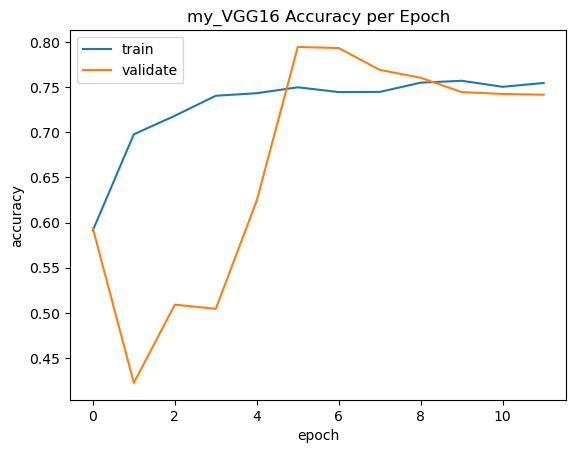

Text(0.5, 1.0, 'my_VGG16 Loss per Epoch')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

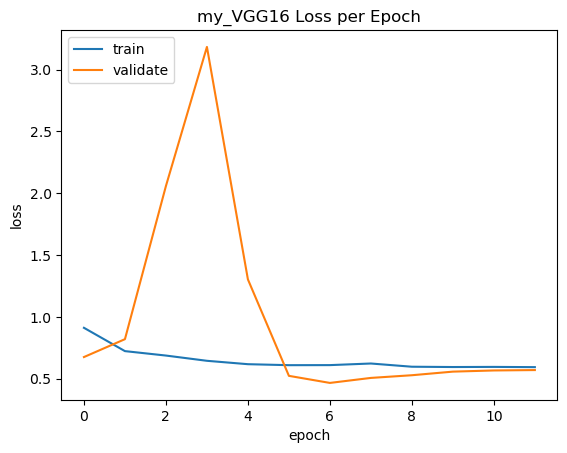

Text(0.5, 1.0, 'my_VGG16 AUC ROC per Epoch')

Text(0, 0.5, 'ROC')

Text(0.5, 0, 'epoch')

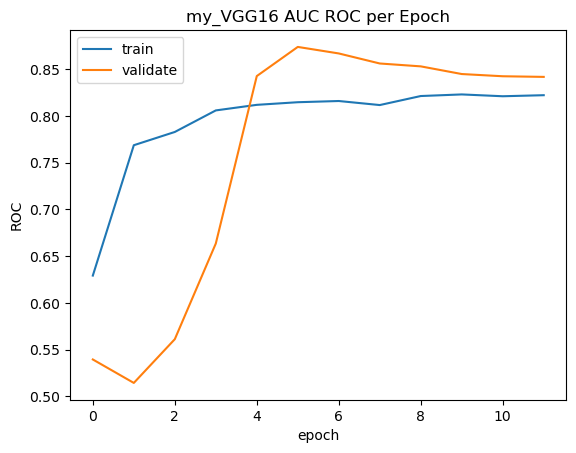

In [ ]:
# plot model accuracy per epoch 
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('my_VGG16 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

# plot model loss per epoch
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('my_VGG16 Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

# plot model ROC per epoch
plt.plot(vgg_history.history['auc'])
plt.plot(vgg_history.history['val_auc'])
plt.title('my_VGG16 AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

####  ResNET 34
ResNet-34 model specifically refers to a version of ResNet with 34 layers. It consists of several residual blocks, each containing skip connections that add the input directly to the output of the block. This allows the gradient to flow through the network more easily during backpropagation, facilitating better learning and reducing the degradation problem that arises when adding more layers to a network.

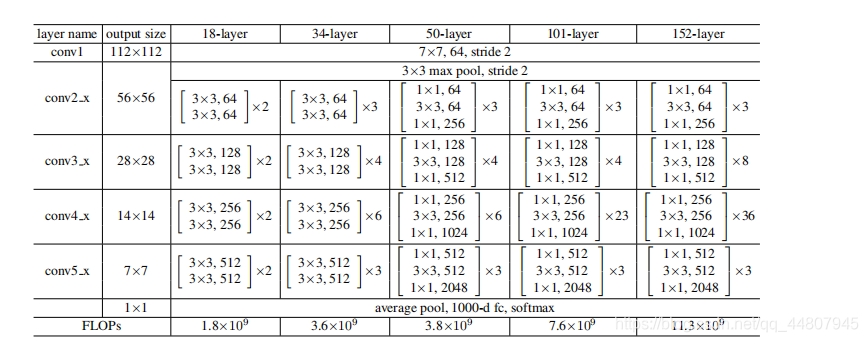

In [10]:
def residual_block(input_tensor, filters, stride=1):
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x

def build_resnet34(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution and pooling layers
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual block configuration (64, 64, 128, 128, 256, 256, 512, 512)
    filter_sizes = [64, 64, 128, 128, 256, 256, 512, 512]
    strides = [1, 1, 2, 1, 2, 1, 2, 1]
    repetitions = [3, 4, 6, 3]

    for filters, stride, repeat in zip(filter_sizes, strides, repetitions):
        for _ in range(repeat):
            x = residual_block(x, filters, stride)
            stride = 1 

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model





In [11]:
K.clear_session()
resnet = build_resnet34(INPUT_SHAPE)

resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 48, 48, 64)   0           ['batch_normalization[0][0]']

In [28]:
lr =0.01
resnet.compile(optimizers.Adam(lr), loss = "binary_crossentropy", metrics = ["accuracy",ROC])


resnet_history = resnet.fit(train_generator, steps_per_epoch = train_step_size, epochs = EPOCH, 
                                validation_data = valid_generator, validation_steps = valid_step_size, 
                                callbacks = [reducelr,earlystopper], verbose = 1)

Epoch 1/20
100/100 [==============================] - 48s 425ms/step - loss: 0.6207 - accuracy: 0.7574 - auc: 0.8408 - val_loss: 197.2018 - val_accuracy: 0.6008 - val_auc: 0.5000 - lr: 0.0100
Epoch 2/20
100/100 [==============================] - 39s 390ms/step - loss: 0.4308 - accuracy: 0.8108 - auc: 0.8747 - val_loss: 4.9183 - val_accuracy: 0.6008 - val_auc: 0.3656 - lr: 0.0100
Epoch 3/20
100/100 [==============================] - 42s 422ms/step - loss: 0.4181 - accuracy: 0.8188 - auc: 0.8828 - val_loss: 3.7287 - val_accuracy: 0.6000 - val_auc: 0.4777 - lr: 0.0100
Epoch 4/20
100/100 [==============================] - 41s 403ms/step - loss: 0.3999 - accuracy: 0.8290 - auc: 0.8929 - val_loss: 1.3311 - val_accuracy: 0.6079 - val_auc: 0.6833 - lr: 0.0100
Epoch 5/20
100/100 [==============================] - 41s 402ms/step - loss: 0.3807 - accuracy: 0.8386 - auc: 0.9042 - val_loss: 0.7352 - val_accuracy: 0.6779 - val_auc: 0.8252 - lr: 0.0100
Epoch 6/20
100/100 [============================

Text(0.5, 1.0, 'ResNET Accuracy per Epoch')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

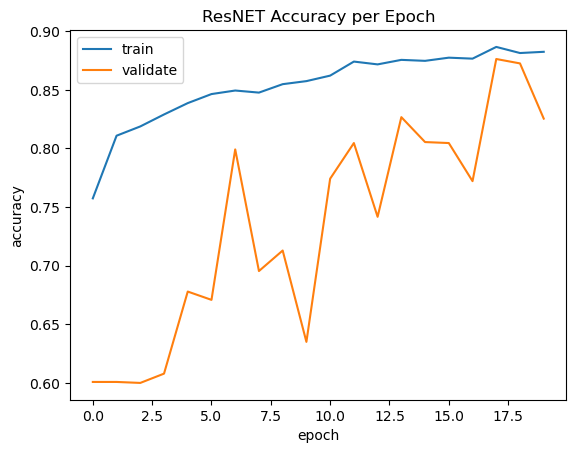

Text(0.5, 1.0, 'ResNET Loss per Epoch')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

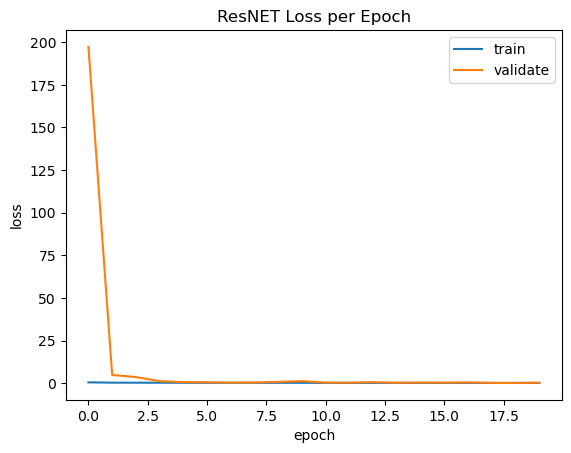

Text(0.5, 1.0, 'ResNET AUC ROC per Epoch')

Text(0, 0.5, 'ROC')

Text(0.5, 0, 'epoch')

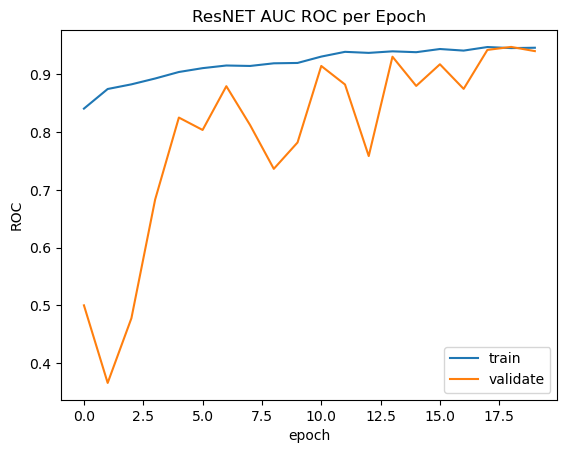

In [29]:
# plot model accuracy per epoch 
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNET Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

# plot model loss per epoch
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNET Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

# plot model ROC per epoch

plt.plot(resnet_history.history['auc'])
plt.plot(resnet_history.history['val_auc'])
plt.title('ResNET AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

#### **TRANSFER LEARNING** VGG16

The model is initialized using weights pre-trained on the ImageNet dataset.Only the convolutional base part is used, which contains the weights for feature extraction

In [20]:


# VGG16 trained on the imagenet dataset, with the top fully connected network removed
vgg_conv_base = VGG16(weights = "imagenet", include_top = False, input_shape =INPUT_SHAPE)
vgg = Sequential()
#conv
vgg.add(vgg_conv_base)
vgg.add(Flatten())
#fc
vgg.add(Dense(4096, use_bias = False))
vgg.add(BatchNormalization())
vgg.add(Activation("relu"))
vgg.add(Dropout(0.5))
#fc
vgg.add(Dense(4096, use_bias = False))
vgg.add(BatchNormalization())
vgg.add(Activation("relu"))
vgg.add(Dropout(0.5))
#fc
vgg.add(Dense(1, activation = "sigmoid"))


Feature reuse:

The first few layers of VGG (including the ones before block5_conv1) usually learn more general image features such as edges, textures, etc. These features are useful for many vision tasks, so keeping the pre-trained weights of these layers can be a good starting point for subsequent tasks.

In [21]:
vgg_conv_base.Trainable = True
set_trainable = False
#The first few layers of VGG (including the layers before block5_conv1) usually learn general image features such as edges, textures, etc.
for layer in vgg_conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
vgg_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [26]:
%%time
K.clear_session()
lr =0.001
vgg.compile(optimizers.Adam(lr), loss = "binary_crossentropy", metrics = ["accuracy",ROC])



vgg_history = vgg.fit(train_generator, steps_per_epoch = train_step_size, epochs = EPOCH, 
                                validation_data = valid_generator, validation_steps = valid_step_size, 
                                callbacks = [reducelr,earlystopper], verbose = 1)


Epoch 1/20
100/100 [==============================] - 48s 451ms/step - loss: 0.6016 - accuracy: 0.7844 - auc: 0.8594 - val_loss: 1.1090 - val_accuracy: 0.6804 - val_auc: 0.7513 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 45s 451ms/step - loss: 0.3933 - accuracy: 0.8335 - auc: 0.9002 - val_loss: 0.8003 - val_accuracy: 0.7208 - val_auc: 0.8047 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 46s 455ms/step - loss: 0.3786 - accuracy: 0.8394 - auc: 0.9077 - val_loss: 0.4003 - val_accuracy: 0.8354 - val_auc: 0.9169 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 50s 495ms/step - loss: 0.3747 - accuracy: 0.8445 - auc: 0.9102 - val_loss: 0.3416 - val_accuracy: 0.8587 - val_auc: 0.9292 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 53s 533ms/step - loss: 0.3541 - accuracy: 0.8484 - auc: 0.9186 - val_loss: 0.4644 - val_accuracy: 0.8058 - val_auc: 0.9324 - lr: 0.0010
Epoch 6/20
100/100 [==============================

Text(0.5, 1.0, 'VGG16 Accuracy per Epoch')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

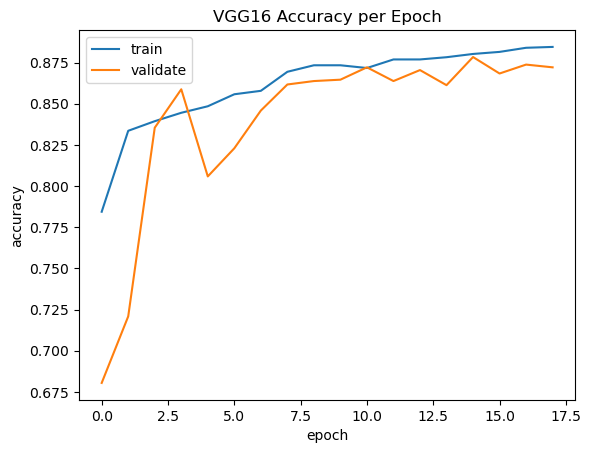

Text(0.5, 1.0, 'VGG16 Loss per Epoch')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

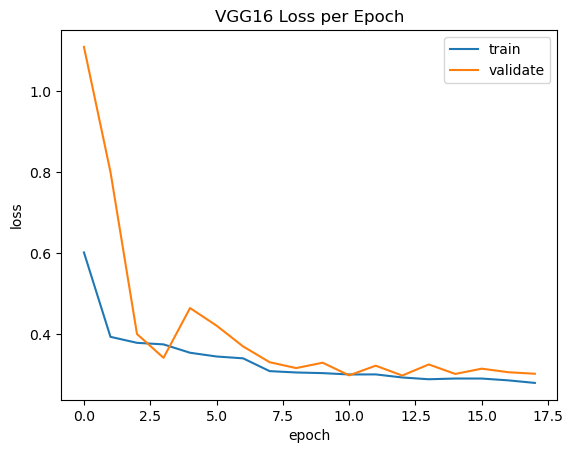

Text(0.5, 1.0, 'VGG16 AUC ROC per Epoch')

Text(0, 0.5, 'ROC')

Text(0.5, 0, 'epoch')

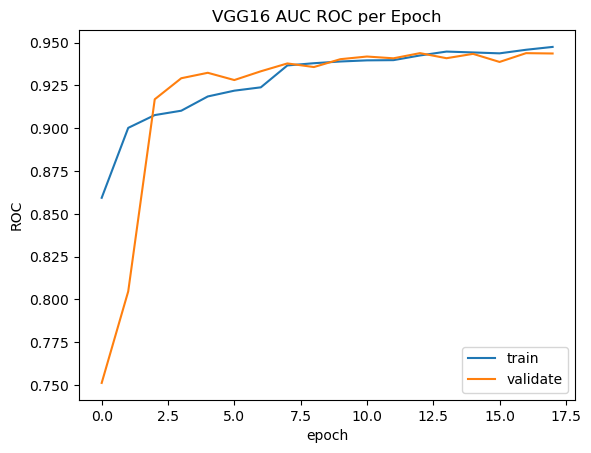

In [27]:
# plot model accuracy per epoch 
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG16 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

# plot model loss per epoch
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG16 Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

# plot model ROC per epoch
plt.plot(vgg_history.history['auc'])
plt.plot(vgg_history.history['val_auc'])
plt.title('VGG16 AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc=0)
plt.show()

## Step4
### Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [14]:
test_imgs_path_df = pd.DataFrame(glob("test/*.tif"), columns = ["path"])
test_imgs_path_df["id"] = test_imgs_path_df["path"].map(lambda x: x.split("\\")[-1].split(".")[0])
test_imgs_path_df.shape
test_imgs_path_df.head()

(57458, 2)

,path,id
0,test\00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,test\000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,test\000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [16]:
# save results data to csv
def save_data(y_prob,filename):
    '''
    predicted data is output as csv
    '''
    
    labels =(y_prob > 0.5) * 1
    print(type(y_prob),labels)
    submission=pd.DataFrame ( {
    "id" : test_imgs_path_df [ "id" ],
 
    "label" :labels
    })
    submission.to_csv ( filename+'_result.csv',index=False)

In [17]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe = test_imgs_path_df, 
    directory = None, 
    x_col = "path", 
    y_col = 'id', 
    target_size = TARGET_SIZE, 
    class_mode = None, 
    batch_size = BATCH_SIZE, 
    seed = RANDOM_STATE, 
    shuffle = False
    )

Found 57458 validated image filenames.


In [58]:
my_vgg_prob = my_VGG16.predict(test_generator, verbose=1)
my_vgg_prob=np.transpose(my_vgg_prob)[0]
save_data(my_vgg_prob,'my_vgg16')

599/599 [==============================] - 153s 255ms/step
<class 'numpy.ndarray'> [0 0 0 ... 0 1 0]


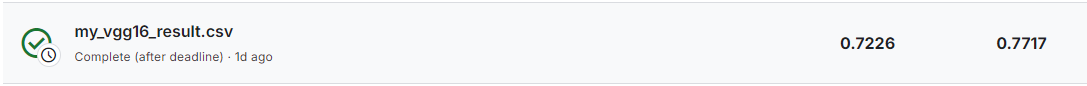

In [18]:
resnet_prob = resnet.predict(test_generator, verbose=1)
resnet_prob=np.transpose(resnet_prob)[0]
save_data(resnet_prob,'resnet')


599/599 [==============================] - 66s 109ms/step
<class 'numpy.ndarray'> [1 1 0 ... 0 1 0]


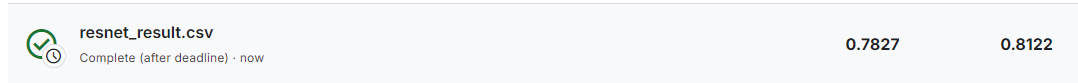

In [ ]:
vgg_prob = vgg.predict(test_generator, verbose=1)

vgg_prob=np.transpose(vgg_prob)[0]

vgg_prob.shape

save_data(vgg_prob,'vgg16')

Improve  performance:
 * Reducing the size of the training dataset,due to hardware constraints, using a smaller dataset might be necessary to train a model at all
 * Adjust the size of batchsize and epoch

But, Increasing the size of batchsize and the number of epochs can improve the accuracy of the model
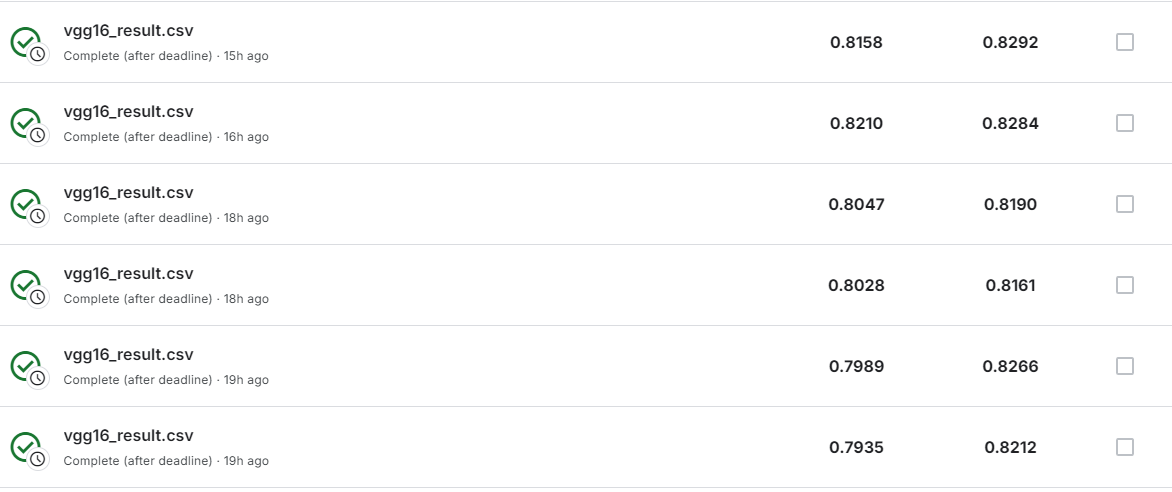

batchsize ->96 -> 128 ->196

A smaller batch size means the model updates more frequently, which can lead to faster convergence but might result in less stable convergence. 

epoch ->10 ->20

If the model is not given enough epochs, it might not converge to an optimal solution, resulting in underfitting, where the model is too simple to capture the underlying patterns in the data.



## Step5
### Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Although the ResNet model is deeper, its parameter utilization is higher due to the existence of residual connections, and the model can still maintain a relatively small number of parameters and higher computational efficiency in the case of deeper. Training a model from scratch requires more computation, but the parameters can be adjusted. The benefit of transfer learning is that the pre-trained weights can be reused, and only a small amount of training is needed to adapt to the new task, thus greatly reducing the training time. And with transfer learning, the knowledge of the pre-trained model can make up for the problem of insufficient data, so that it can also achieve good performance on small datasets.
